In [108]:
# Imports
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.metrics import MAE, SMAPE, MAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer, encoders
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
import torch
import pandas as pd
import numpy as np
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
import math
import plotly.graph_objs as go


In [109]:
# Read raw data
data = pd.read_csv("Spieldatensatz.csv")

In [110]:
# Meta-parameters for modeling
batch_size = 128
max_prediction_length = 30
max_encoder_length = 35
max_epochs = 50
hidden_size = 64
attention_head_size = 2
learning_rate = 0.03
desired_quantiles = [0.1, 0.5, 0.9]
nDay_test = 365 # number of days in test dataset
nDay_validation = 200 # number of days in validation dataset

In [114]:
#Generate dataset to use for training and forecasting
data_simple = data
holiday = ['NotCondensed_Allerheiligen', 'NotCondensed_Aschermittwoch', 'NotCondensed_BussUndBettag', 'NotCondensed_DritterAdvent', 'NotCondensed_ErsterAdvent', 'NotCondensed_ErsterMai', 'NotCondensed_ErsterWeihnachtstag', 'NotCondensed_Fastnacht', 'NotCondensed_Fastnachtssamstag', 'NotCondensed_Fastnachtssonntag', 'NotCondensed_Fronleichnam', 'NotCondensed_Gruendonnerstag', 'NotCondensed_Halloween', 'NotCondensed_Heiligabend', 'NotCondensed_HeiligeDreiKoenige', 'NotCondensed_Himmelfahrt', 'NotCondensed_Karfreitag', 'NotCondensed_Karsamstag', 'NotCondensed_MariaeHimmelfahrt', 'NotCondensed_Martinstag', 'NotCondensed_Muttertag', 'NotCondensed_Neujahr', 'NotCondensed_Nikolaus', 'NotCondensed_Ostermontag', 'NotCondensed_Ostersonntag', 'NotCondensed_Palmsonntag', 'NotCondensed_Pfingstmontag', 'NotCondensed_Pfingstsonntag', 'NotCondensed_Rosenmontag', 'NotCondensed_Silvester', 'NotCondensed_TagDerDeutschenEinheit', 'NotCondensed_Totensonntag', 'NotCondensed_Valentinstag', 'NotCondensed_VierterAdvent', 'NotCondensed_Volkstrauertag', 'NotCondensed_Weiberfastnacht', 'NotCondensed_ZweiterAdvent', 'NotCondensed_ZweiterWeihnachtstag', 'NotCondensed_ReformationstagAb2017', 'NotCondensed_Reformationstag', 'NotCondensed_Frauentag_ab_2023', 'NotCondensed_ReformationstagNur2017', 'NotCondensed_Frauentag', 'NotCondensed_BefreiungVonNazis']
data_simple['none'] = (data_simple[holiday].sum(axis=1) == 0).astype(int)
holiday += ['none']
data_simple['holiday'] = data_simple[holiday].idxmax(1)

data_simple = data[["Date", "Branch", "Group", "Sales", "Monat", "Wochentag",
                    "TagImMonat", "Jahr", "MTXWTH_Temp_max", "MTXWTH_Rain", "ShiftLength",
                    "holiday"]]
data_simple = data_simple[data_simple["Branch"] < 5]
data_simple = data_simple[data_simple["Sales"].apply(math.isnan) == False]
data_simple = data_simple[lambda x: x.Sales > 0]
data_simple = data_simple[data_simple["ShiftLength"].apply(math.isnan) == False]
data_simple["Date"] = pd.to_datetime(data_simple["Date"], format="%Y-%m-%d")
first_date = min(data_simple["Date"])
last_date = max(data_simple["Date"])
data_simple["time_idx"] = (data_simple["Date"] - first_date).dt.days
data_simple = data_simple.drop("Date", axis = 1)

# Categorical variables _have_ to be string
data_simple["Branch"] = data_simple["Branch"].apply(str)
data_simple["Wochentag"] = data_simple["Wochentag"].apply(str)
data_simple["Group"] = data_simple["Group"].apply(str)
data_simple["Monat"] = data_simple["Monat"].apply(str)

#data_simple["TagImMonat"] = data_simple["TagImMonat"].apply(str)
# holidays = ["NotCondensed_ErsterMai", "NotCondensed_ErsterWeihnachtstag",
#             "NotCondensed_Heiligabend", "NotCondensed_Himmelfahrt",
#             "NotCondensed_Karfreitag", "NotCondensed_Karsamstag",
#             "NotCondensed_Neujahr", "NotCondensed_Ostermontag",
#             "NotCondensed_Ostersonntag", "NotCondensed_Pfingstmontag",
#             "NotCondensed_Pfingstsonntag", "NotCondensed_Silvester",
#             "NotCondensed_TagDerDeutschenEinheit", "NotCondensed_ZweiterWeihnachtstag"]
# for hol in holidays:
#     data_simple[hol] = data_simple[hol].apply(str)

# Constant variable letting the model now that the branch is Open
# When the grid is expanded, this will be filled with "F" 
data_simple["OpenDay"] = "O"

categoricals = ["Monat", "Wochentag", "OpenDay", "holiday"]
#categoricals.extend(holidays)

In [115]:
# Build training and test dataset configuration
validation_cutoff = data_simple["time_idx"].max() - nDay_test
training_cutoff = validation_cutoff - nDay_validation

data_simple['weight'] = (data_simple['Sales'] > 0).astype(int) # if sales are 0 we dont want these observations influencing loss / gradient computations

data_for_training = data_simple[lambda x: x.time_idx <= training_cutoff]
data_for_validation = data_simple[lambda x: (x.time_idx > training_cutoff) & (x.time_idx <= validation_cutoff)]
data_for_test = data_simple[lambda x: x.time_idx > validation_cutoff]
# ascertain that training dataset length is a multiple of batch_size
tooMuch = len(data_for_training) % batch_size
data_for_training = data_for_training[tooMuch:len(data_for_training)]

training = TimeSeriesDataSet(
    data_for_training,
    time_idx="time_idx",
    target="Sales",
    weight = 'weight',
    group_ids=["Branch", "Group"],
    # keep encoder length long (as it is in the validation set)
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Branch", "Group"],
    static_reals=[],
    time_varying_known_categoricals=categoricals,
    time_varying_known_reals=["time_idx",
                              "MTXWTH_Temp_max", "MTXWTH_Rain", "ShiftLength", "TagImMonat"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    target_normalizer=GroupNormalizer(
        groups=["Branch", "Group"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    constant_fill_strategy={"Sales": 0, "OpenDay": "F"},
    categorical_encoders={
        'OpenDay': encoders.NaNLabelEncoder(add_nan=True)
    },
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, 
    data_for_validation, 
    predict=False, 
    stop_randomization=True)

test = TimeSeriesDataSet.from_dataset(
    training, 
    data_for_test, 
    predict=False, 
    stop_randomization=True)

# create dataloaders for model
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size*10, num_workers=0)
test_dataloader = test.to_dataloader(
    train=False, batch_size=batch_size*10, num_workers=0)

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning:

Found 1 unknown classes which were set to NaN

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning:

Found 1 unknown classes which were set to NaN

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_forecasting\data\encoders.py:318: UserWarning:

Found 1 unknown classes which were set to NaN



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\utilities.py:70: PossibleUserWarning:

`max_epochs` was not set. Setting it to 1

Number of parameters in network: 29.2k


`Trainer.fit` stopped: `max_steps=100` reached.
Finding best initial lr: 100%|██████████| 100/100 [00:23<00:00,  4.33it/s]
Learning rate set to 5.888436553555889e-06
Restoring states from the checkpoint path at c:\Projekte\mtx-temporalFusionTransformer\.lr_find_5838d709-068e-48d3-a340-8cb409cea96b.ckpt
Restored all states from the checkpoint at c:\Projekte\mtx-temporalFusionTransformer\.lr_find_5838d709-068e-48d3-a340-8cb409cea96b.ckpt


suggested learning rate: 5.888436553555889e-06


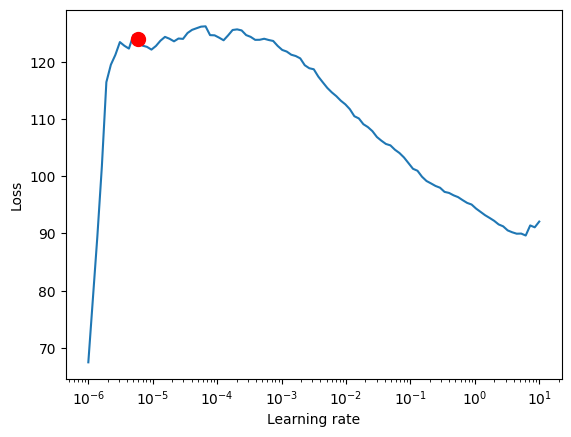

C:\Users\lvdburchard\AppData\Local\Temp\ipykernel_3600\1094098391.py:39: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



In [102]:
# Optional: Determine learning rate
if False:
    # configure network and trainer
    pl.seed_everything(42)
    trainer = pl.Trainer(
        accelerator="cpu",
        # clipping gradients is a hyperparameter and important to prevent divergance
        # of the gradient for recurrent neural networks
        gradient_clip_val=0.1,
    )


    tft = TemporalFusionTransformer.from_dataset(
        training,
        # not meaningful for finding the learning rate but otherwise very important
        learning_rate=learning_rate,
        hidden_size=hidden_size,  # most important hyperparameter apart from learning rate
        # number of attention heads. Set to up to 4 for large datasets
        attention_head_size=attention_head_size,
        dropout=0.1,  # between 0.1 and 0.3 are good values
        hidden_continuous_size=8,  # set to <= hidden_size
        loss=QuantileLoss(quantiles = desired_quantiles),
        optimizer="Ranger"
        # reduce learning rate if no improvement in validation loss after x epochs
        # reduce_on_plateau_patience=1000,
    )
    print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

    res = Tuner(trainer).lr_find(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
        max_lr=10.0,
        min_lr=1e-6,
    )

    print(f"suggested learning rate: {res.suggestion()}")
    fig = res.plot(show=True, suggest=True)
    fig.show()


In [116]:

# configure network and trainer
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logging results to a tensorboard
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    #limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=0.25,
    hidden_continuous_size=8,
    loss=QuantileLoss(quantiles = desired_quantiles),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 240.0k


c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.



In [117]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 676   
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 12.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 12.3 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 9:  29%|██▉       | 94/325 [00:46<01:55,  2.00it/s, v_num=27, train_loss_step=22.70, val_loss=68.50, train_loss_epoch=21.30] 

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:52: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [118]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path = 'lightning_logs/lightning_logs/version_27/checkpoints/epoch=8-step=2925.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
raw_predictions = best_tft.predict(test_dataloader, mode="raw", return_index=True)

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

c:\Users\lvdburchard\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning:

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on t

In [119]:
# convert predictions to pd.DataFrame

def raw_preds_to_df(raw,idx_offset,quantiles = None):
    """
    raw is output of model.predict with return_index=True
    quantiles can be provided like [0.1,0.5,0.9] to get interpretable quantiles
    in the output, time_idx is the first prediction time index (one step after knowledge cutoff)
    pred_idx the index of the predicted date i.e. time_idx + h - 1
    """
    index = raw.index
    preds = raw.output.prediction
    dec_len = raw.output.prediction.shape[1]
    n_quantiles = preds.shape[-1]
    preds_df = pd.DataFrame(index.values.repeat(dec_len * n_quantiles, axis=0),columns=index.columns)
    preds_df = preds_df.assign(Horizon=np.tile(np.repeat(np.arange(1,1+dec_len),n_quantiles),len(preds_df)//(dec_len*n_quantiles)))
    preds_df = preds_df.assign(Quantile=np.tile(np.arange(n_quantiles),len(preds_df)//n_quantiles))
    preds_df = preds_df.assign(Prediction=preds.flatten().cpu().numpy())
    if quantiles is not None:
        preds_df['Quantile'] = preds_df['Quantile'].map({i:q for i,q in enumerate(quantiles)})

    preds_df['pred_idx'] = preds_df['time_idx'] + preds_df['Horizon'] - 1
    preds_df['Date'] = pd.to_datetime(idx_offset)
    preds_df['Date'] = preds_df['Date'] + preds_df['pred_idx'].apply(pd.DateOffset)
    return preds_df

pred = raw_preds_to_df(raw_predictions, first_date)
pred = pred.drop_duplicates() # for unknown reasons, predictions include many duplicated items
# default quantiles are  [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
# therefore, Quantile=3 is median
print(pred[lambda x: (x.Branch == "1") & (x.Group == "5") & (x.Horizon == 1)])

C:\Users\lvdburchard\AppData\Local\Temp\ipykernel_3600\859612390.py:23: PerformanceWarning:

Adding/subtracting object-dtype array to DatetimeArray not vectorized.



       time_idx Branch Group  Horizon  Quantile   Prediction pred_idx  \
116640     2404      1     5        1         0  1638.444336     2404   
116641     2404      1     5        1         1  1753.244629     2404   
116642     2404      1     5        1         2  1874.437988     2404   
116730     2405      1     5        1         0  1494.058960     2405   
116731     2405      1     5        1         1  1598.836426     2405   
...         ...    ...   ...      ...       ...          ...      ...   
145710     2733      1     5        1         0  1597.771729     2733   
145711     2733      1     5        1         1  1702.755249     2733   
145712     2733      1     5        1         2  1825.544922     2733   
760142     2553      1     5        1         2  2040.352295     2553   
760502     2586      1     5        1         2  1916.236450     2586   

                       Date  
116640  2022-08-01 00:00:00  
116641  2022-08-01 00:00:00  
116642  2022-08-01 00:00:00  
116

In [121]:
sales = data[["Date", "Branch", "Group", "Sales"]].copy()
sales["Branch"] = sales["Branch"].apply(str)
sales["Group"] = sales["Group"].apply(str)
sales["Date"] = pd.to_datetime(sales["Date"], format="%Y-%m-%d")
pred["Date"] = pd.to_datetime(pred["Date"], format="%Y-%m-%d")

test = pd.merge(pred[["Date", "Branch", "Group", "Horizon", "Quantile", "Prediction"]], sales, how="inner", on=["Date", "Branch", "Group"])

medianQuantile = desired_quantiles.index(0.5)
evaluateMe = test[(test["Horizon"] == 1) & (test["Quantile"] == medianQuantile)]
evaluateMe = evaluateMe[lambda x: x.Sales > 0]
WAPE = 100 * np.sum(np.abs(evaluateMe["Prediction"] - evaluateMe["Sales"])) / np.sum(evaluateMe["Sales"])
print(evaluateMe)
print(WAPE)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8                                                                                             │
│    9 medianQuantile = desired_quantiles.index(0.5)                                               │
│   10 evaluateMe = test[(test["Horizon"] == 1) & (test["Quantile"] == medianQuantile)]            │
│ ❱ 11 evaluateMe = evaluteMe[lambda x: x.Sales > 0]                                               │
│   12 WAPE = 100 * np.sum(np.abs(evaluateMe["Prediction"] - evaluateMe["Sales"])) / np.sum(eva    │
│   13 print(evaluateMe)                                                                           │
│   14 print(WAPE)                                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'evaluteMe' is not defined

In [92]:

plotMe = evaluateMe[lambda x: (x.Branch == "1") & (x.Group == "1")]
plot = go.Figure()
plot.add_trace(go.Scatter(x=plotMe["Date"], y=plotMe["Sales"],name="Sales"))
plot.add_trace(go.Scatter(x=plotMe["Date"], y=plotMe["Prediction"],name="Prediction"))
plot.show()